## **Customer Segmentation Using K-Means Clustering**

### Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import torch
import matplotlib.pyplot as plt

### Creating a synthetic dataset

In [2]:
data = {
    'Customer ID': np.arange(1, 201),
    'Age': np.random.randint(18, 70, 200),
    'Annual Income (k$)': np.random.randint(15, 150, 200),
    'Spending Score (1-100)': np.random.randint(1, 100, 200)
}

In [3]:
df = pd.DataFrame(data)

In [4]:
df.head()

,Customer ID,Age,Annual Income (k$),Spending Score (1-100)
0,1,61,42,83
1,2,56,98,21
2,3,41,118,54
3,4,33,145,95
4,5,22,21,95


In [5]:
df.describe()

,Customer ID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,41.740000,81.095000,51.940000
std,57.879185,15.103742,39.974187,29.071328
min,1.000000,18.000000,15.000000,2.000000
25%,50.750000,28.000000,43.000000,26.500000
50%,100.500000,39.500000,80.000000,51.500000
75%,150.250000,55.000000,116.250000,78.000000
max,200.000000,69.000000,149.000000,99.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Customer ID             200 non-null    int64
 1   Age                     200 non-null    int32
 2   Annual Income (k$)      200 non-null    int32
 3   Spending Score (1-100)  200 non-null    int32
dtypes: int32(3), int64(1)
memory usage: 4.0 KB


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
X = torch.tensor(np.array(list(zip(data['Age'], data['Annual Income (k$)'], data['Spending Score (1-100)']))), dtype=torch.float32)

In [9]:
if isinstance(X, np.ndarray):
    X = torch.from_numpy(X).float()  
elif isinstance(X, torch.Tensor):
    X = X.clone().detach().float() 

print("X Shape:", X.shape)

X Shape: torch.Size([200, 3])


### Generate synthetic 2D data

In [10]:
torch.manual_seed(42)

In [11]:
num_samples = 200
num_clusters = 2

### Define the Model

In [31]:
class KMeansClustering:
    def __init__(self, num_clusters, num_samples, random_state=42):
        self.n_clusters = num_clusters
        self.max_iters = num_samples
        self.random_state = random_state
        self.centroids = None

    def initialize_centroids(self, X):
        n_samples = X.shape[0]
        if self.random_state is not None:
            torch.manual_seed(self.random_state)
        indices = torch.randint(0, n_samples, (self.n_clusters,))
        self.centroids = X[indices]

    def compute_distances(self, X):
        X_expanded = X.unsqueeze(1)
        centroids_expanded = self.centroids.unsqueeze(0)
        return torch.norm(X_expanded - centroids_expanded, dim=2)

    def assign_clusters(self, X):
        distances = self.compute_distances(X)
        return torch.argmin(distances, dim=1)

    def update_centroids(self, X, labels):
        new_centroids = []
        for i in range(self.n_clusters):
            mask = labels == i
            cluster_points = X[mask]
            if len(cluster_points) > 0:
                new_centroids.append(cluster_points.mean(dim=0))
            else:
                new_centroids.append(self.centroids[i])
        self.centroids = torch.stack(new_centroids)

    def fit(self, X):
        self.initialize_centroids(X)
        for _ in range(self.max_iters):
            labels = self.assign_clusters(X)
            prev_centroids = self.centroids.clone()
            self.update_centroids(X, labels)
            if torch.allclose(prev_centroids, self.centroids, atol=1e-4):
                break
        return labels

In [32]:
num_samples = X.shape[0]  
kmeans = KMeansClustering(num_clusters=3, num_samples=num_samples)
labels = kmeans.fit(X)
print("Final Cluster Labels:", labels)
print("Final Centroids:", kmeans.centroids)

Final Cluster Labels: tensor([1, 0, 0, 0, 1, 2, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 1, 1, 2,
        1, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 1, 2, 0, 0, 0, 0,
        2, 0, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 2, 2, 2,
        2, 1, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 0, 2, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2,
        2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1,
        1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 0, 1,
        0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2, 1, 0, 0,
        1, 1, 2, 0, 0, 2, 1, 0])
Final Centroids: tensor([[ 39.7229, 121.5783,  46.3855],
        [ 42.5410,  56.0820,  81.3771],
        [ 43.8571,  48.3393,  28.1071]])


### Visualizing the Clusters

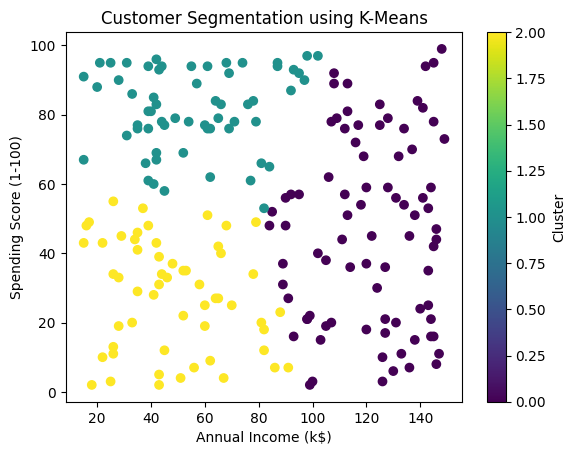

In [34]:
df['Cluster'] = labels.numpy()
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segmentation using K-Means')
plt.colorbar(label='Cluster')
plt.show()